Classi: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


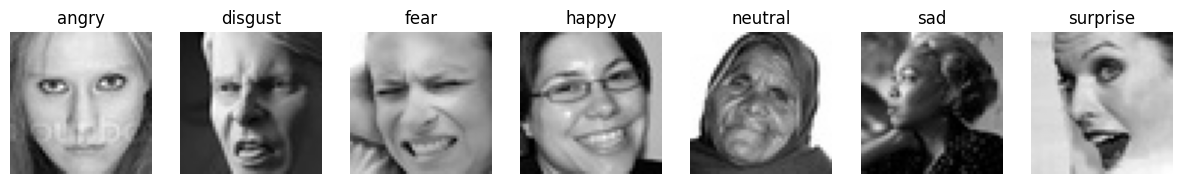

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import random

base_path = Path("data/fer2013/train")
classes = [d.name for d in base_path.iterdir() if d.is_dir()]
print("Classi:", classes)

# Mostra 1 immagine a caso per classe
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))
for ax, cls in zip(axes, classes):
    img_path = random.choice(list((base_path / cls).glob("*.jpg")))
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(cls)
    ax.axis('off')
plt.show()


          num_images
angry           3995
disgust          436
fear            4097
happy           7215
neutral         4965
sad             4830
surprise        3171


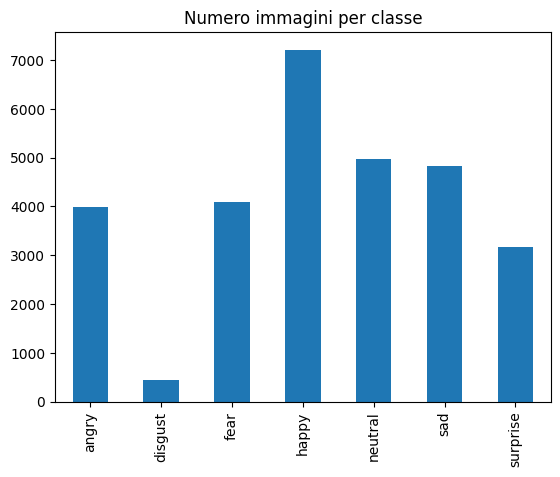

In [ ]:


counts = {cls: len(list((base_path / cls).glob("*.jpg"))) for cls in classes}
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['num_images'])
print(df_counts)
df_counts.plot(kind='bar', legend=False, title='Numero immagini per classe')
plt.show()



In [6]:
total_images = sum(counts.values())
for cls, count in counts.items():
    print(f"{cls}: {count} immagini ({count/total_images*100:.2f}%)")
print("Media immagini per classe:", df_counts['num_images'].mean())
print("Deviazione standard:", df_counts['num_images'].std())


angry: 3995 immagini (13.92%)
disgust: 436 immagini (1.52%)
fear: 4097 immagini (14.27%)
happy: 7215 immagini (25.13%)
neutral: 4965 immagini (17.29%)
sad: 4830 immagini (16.82%)
surprise: 3171 immagini (11.05%)
Media immagini per classe: 4101.285714285715
Deviazione standard: 2052.7749279358186


Processing e Data Augmentation

In [15]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(),  # già in grigio ma nel caso servisse
    transforms.Resize((48, 48)),  # FER2013 è 48x48
    transforms.ToTensor(),  # converte in tensore
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [16]:
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.8,1.0))
])


Pesare la Loss

In [10]:
import torch
import torch.nn as nn

# Esempio: pesi inversamente proporzionali al numero di immagini
counts_list = [counts[cls] for cls in classes]
weights = [total_images/c for c in counts_list]
weights = torch.tensor(weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights)


Divisione del DataSet

In [ ]:
from sklearn.model_selection import train_test_split

# Raccogli tutti i file con le rispettive classi
all_images = []
all_labels = []

for cls in classes:
    for img_path in (base_path / cls).glob("*.jpg"):
        all_images.append(img_path)
        all_labels.append(cls)

# 70% train, 15% val, 15% test
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_imgs)} immagini")
print(f"Validation: {len(val_imgs)} immagini")
print(f"Test: {len(test_imgs)} immagini")
